In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy
from scipy.spatial.distance import pdist, squareform
import sklearn
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.model_selection import KFold
import tqdm
import requests
import time

In [179]:
def compute_rwr_original_sparse(ppi_files,restart_prob,ngene,nets):
    ''' 
    - ppi_files: list of network file paths
    - restart_prob: RWR restart probability
    - ngene: number of genes

    walks[i,:,:]: each column is the stationary distribution of a node
    '''
    n_file = len(ppi_files)
    e = np.ones(ngene)
    I = np.eye(ngene)
    walks = np.zeros((n_file,ngene,ngene))
    for i in range(n_file):
        A = nets[i,:,:]
        d = A @ e
        P = A / d # transition matrix
        W = (I - (1 - restart_prob) * P)
        W = np.linalg.inv(W)
        W = W * restart_prob 
        walks[i,:,:] = W
    return walks

In [180]:
# there are subtle differences between matlab implementation and python implementation.
# It's caused by after RWR, there are some values that are extremely small, 
# for example, in network 6, [1825,943], its value is 1e-17 ish, after taking log, the log becomes -38
# these differences accumulated and as a result, the eigenvalues become different.
# After filtering out the extreme numbers in matlab code, the two results become the same.
def svd_embed_sparse_func(walks, ngene, embed_dim):
    n_net = walks.shape[0]
    mat = np.zeros((ngene,ngene))
    W_updated = np.zeros_like(walks)
    for i in range(n_net):
        W = walks[i,:,:]
        W[W<=1e-8] = 0
        W = np.log(W, where = W > 1e-8)
        W_updated[i,:,:] = W
        tmp = W.T @ W
        mat = mat + tmp
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(mat,k=embed_dim)
    x = np.diag(np.sqrt(np.sqrt(eigenvalues))) @ eigenvectors.T
    return np.real(x)

In [181]:
def load_train_test_anno(rand,fold,org,ont_type,ont_size1,ont_size2):
    '''
    - rand: 1 2 3 4 5
    - fold: 1 2 3 4 5
    - org: "Ecoli" or "yeast"
    '''
    file_name = 'data/train_test_split/'+org+'/rand' + str(rand) +'/fold' + str(fold) + '_' + ont_type+ '_' +  str(ont_size1)+ '_' +  str(ont_size2)+ '_train_anno.txt'
    train = pd.read_csv(file_name,header=None,sep = '\t')
    file_name = 'data/train_test_split/'+org+'/rand' + str(rand) +'/fold' + str(fold) + '_' + ont_type+ '_' +  str(ont_size1)+ '_' +  str(ont_size2)+ '_test_anno.txt'
    test = pd.read_csv(file_name,header=None,sep = '\t')
    return train.to_numpy(), test.to_numpy()

In [182]:
def augment_graph(nets, ngene, gene_clusters, mustlink_weight, cannotlink_weight):
    '''
    - nets: original adjacency matrices directly read from PPI files
    - gene_clusters: (num_clusers, num_genes), binary matrix indicating which gene belongs to which clusters
    '''
    n_nets = nets.shape[0]
    n_clusters = gene_clusters.shape[0]
    augmented = np.zeros((n_nets,(ngene+n_clusters),(ngene+n_clusters)))
    for i in range(n_nets):
        A = nets[i,:,:]
        A_block = np.block([[A,mustlink_weight*gene_clusters.T],[mustlink_weight*gene_clusters,cannotlink_weight*np.ones((n_clusters,n_clusters))]])
        np.fill_diagonal(A_block,0)
        zero_rows = np.all(np.absolute(A_block) == 0, axis=1)
        diag_indices = np.arange(ngene+n_clusters)
        A_block[diag_indices[zero_rows], diag_indices[zero_rows]] = 1
        augmented[i,:,:] = A_block
    return augmented

In [183]:
def augmented_RWR(augmented_nets, restart_prob):
    n_nets = augmented_nets.shape[0]
    n_nodes = augmented_nets.shape[1]
    augmented_walks = np.zeros((n_nets,n_nodes,n_nodes))
    e = np.ones(n_nodes)
    for i in range(n_nets):
        A = augmented_nets[i,:,:]
        d = np.absolute(A) @ e
        L = np.diag(d) - (1-restart_prob)*A
        L_inv = np.linalg.inv(L)
        W = restart_prob*(np.diag(d) @ L_inv)
        augmented_walks[i,:,:] = W
    return augmented_walks


In [184]:
def augmented_SVD_with_cannolink(aug_walks, embed_dim):
    n_net = aug_walks.shape[0]
    n_node = aug_walks.shape[1]
    mat = np.zeros((n_node,n_node))
    W_updated = np.zeros_like(aug_walks)
    for i in range(n_net):
        W = aug_walks[i,:,:]
        min_entry = W.min()
        if min_entry > 0:
            min_entry = 0.0
        W = W - min_entry
        W[W<=1e-8] = 0
        W = np.log(W, where = W > 1e-8)
        W_updated[i,:,:] = W
        tmp = W.T @ W
        mat = mat + tmp
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(mat,k=embed_dim)
    x = np.diag(np.sqrt(np.sqrt(eigenvalues))) @ eigenvectors.T
    return np.real(x)

In [185]:
def get_knn_ind(embed,train_anno):
    '''
    parameters:
    - embed: (dim, num_gene), protein embeddings
    - train_anno: annotations for training proteins
    output:
    dist_mat: n_gene x n_gene
    sorted_ind: ngene x (ngene-1), top n labels
    '''
    n_gene = train_anno.shape[1]
    train_idx = np.where(sum(train_anno)>0)[0]
    # embed = embed[:n_gene,:n_gene]
    dist_mat = squareform(pdist(embed.T))
    dist_mat = dist_mat[:n_gene,:n_gene] # symmetrical
    np.fill_diagonal(dist_mat, 1e8)
    # mask = np.ones(n_gene, dtype=bool)
    # mask[train_idx] = False
    # dist_mat[:, mask] = 1e8

    sorted_ind = np.argsort(dist_mat, axis=1)
    # sorted_ind = sorted_ind[:,1:] # each row, gene's nearest neighbors
    
    return dist_mat, sorted_ind


In [186]:
def majority_vote(dist_mat, knn_mat, train_anno, test_anno,k, weighted=True):
    '''
    parameters:
    - dist_mat: n_gene x n_gene
    - knn_mat: ngene x (ngene-1), sorted labels
    - train_anno: n_label x n_gene
    - test_anno: n_label x n_gene
    - k: number of nearest neighbors
    - weighted: boolean, whether doing weighted majority vote or not
    output:
    - final_scores: n_label x n_test, normalized scores of each label
    - num_voters: vector of numbers of voting nodes
    '''
    train_idx = np.where(sum(train_anno)>0)[0]
    test_idx = np.where(sum(test_anno)>0)[0]
    final_scores = np.zeros((train_anno.shape[0],len(test_idx)))
    num_voters = []
    updated_voters = []
    c = 0
    for index, i in enumerate(test_idx):
        nn = knn_mat[i,:k]
        nn_labeled = nn[np.isin(nn, train_idx)] 
        # num_voters.append(len(nn_labeled))
        if len(nn_labeled) == 0: # if within the first k neighbors, no neighbor is labeled, then use the nearest neighbor with label
            voting_node = knn_mat[i,:][np.isin(knn_mat[i,:], train_idx)][0]
            scores = np.array(train_anno[:,voting_node])
            scores = scores / sum(scores)
            num_voters.append(len(nn_labeled))
            tmp = [voting_node]
            updated_voters.append(tmp)
        else:
            votes = np.array(train_anno[:,nn_labeled])
            if weighted:
                d = dist_mat[i,nn_labeled]
                # print(d)
                d = d[np.nonzero(d)]
                # print(d)
                votes = np.array(train_anno[:,nn_labeled[np.nonzero(d)]])
                tmp = nn_labeled[np.nonzero(d)]
                updated_voters.append(tmp)
                num_voters.append(len(d))
                if len(d) == 0:
                    c += 1
                    voting_node = np.random.choice(train_idx)
                    scores = np.array(train_anno[:,voting_node])
                    scores = scores / sum(scores)
                else:
                    weights = 1 / d
                    # print(weights.shape)
                    scores = votes @ weights.T
                    scores = scores / sum(scores)
                    # print(scores.shape)
            else:
                num_voters.append(len(nn_labeled))
                updated_voters.append(nn_labeled)
                scores = np.sum(votes,axis=1)
                scores = scores / sum(scores)
        
        final_scores[:,index] = np.squeeze(scores)
    # print(c)
    return final_scores, num_voters,updated_voters


In [187]:
def acc_top1_pred(test_scores, test_anno):
    '''
    for each test gene, find the label with the highest predicted score, use it as the predicted label
    accuracy is defined as (#predicted label in test true labels) / (#test genes)
    problems: if there's a tie, the one with smaller index will be used
    parameters:
    - test_scores: n_label x n_test
    - test_anno: n_label x n_gene
    output:
    - acc: accuracy score
    '''
    test_idx = np.where(sum(test_anno)>0)[0]
    zero_idx = np.where(np.sum(test_scores,axis=0)==0)[0]
    mask = np.ones(len(test_idx), dtype=bool)
    mask[zero_idx] = False
    test_anno = test_anno[:,test_idx] # n_label x n_test
    sorted_index = np.argsort(-1*test_scores,axis=0) # n_label x n_test, with row 0 the highest predicted label for each gene
    true_pred = test_anno[sorted_index[0,:], np.arange(test_anno.shape[1])]
    true_pred = true_pred[mask]
    # print(len(zero_idx))
    acc = np.mean(true_pred)
    return acc,true_pred
    

In [188]:
def f1_auprc_pred(test_scores, test_anno,top_n):
    '''
    for each test gene, find the labels with the top_n highest predicted scores, use them as the predicted labels
    f1 is defined as 2*TP / 2*TP + FP + FN
    probelms: if there's a tie, the one with smaller index will be used, only top n predictions will be considered, it will increase the number of FN
    parameters:
    - test_scores: n_label x n_test
    - test_anno: n_label x n_gene
    - top_n: int, the number of labels to be predicted
    output:
    - acc: accuracy score
    '''
    test_idx = np.where(sum(test_anno)>0)[0]
    zero_idx = np.where(np.sum(test_scores,axis=0)==0)[0]

    mask = np.ones(len(test_idx), dtype=bool)
    mask[zero_idx] = False
    test_anno = test_anno[:,test_idx] # n_label x n_test
    
    test_anno = test_anno[:,mask]
    test_scores = test_scores[:,mask]
    sorted_index = np.argsort(-1*test_scores,axis=0) # n_label x n_test, with row 0 the highest predicted label for each gene
    top_ind = sorted_index[:top_n,:].flatten()
    pred = np.zeros_like(test_anno)
    cols = np.tile(np.arange(test_anno.shape[1]), top_n)
    pred[top_ind, cols] = 1
    # print(pred)
    f1 = sklearn.metrics.f1_score(test_anno.flatten(),pred.flatten())
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test_anno.flatten(), pred.flatten())
    auprc = sklearn.metrics.auc(recall, precision)
    return f1, auprc
    


In [189]:
'''
for each augmented node, randomly choose a fixed number of nodes to connect to
the number of genes that each augmented node connects to are the same except for the last one
'''
def random_split_vector(train_anno,n_gene, num_sub_vectors,seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    input_vector = np.where(sum(train_anno)>0)[0]
    # input_vector = np.arange(n_gene)
    
    if num_sub_vectors <= 0 or num_sub_vectors > len(input_vector):
        raise ValueError("Invalid number of sub-vectors")
    
    shuffled_vector = np.random.permutation(input_vector)
    sub_vector_size = len(shuffled_vector) // num_sub_vectors
    
    group_matrix = np.zeros((num_sub_vectors, len(input_vector)), dtype=int)
    res_matrix = np.zeros((num_sub_vectors, n_gene), dtype=int)
    
    start_index = 0
    for i in range(num_sub_vectors):
        end_index = start_index + sub_vector_size
        
        if i == num_sub_vectors - 1:
            end_index = len(shuffled_vector)
        
        selected_indices = shuffled_vector[start_index:end_index]
        
        group_matrix[i, np.isin(shuffled_vector, selected_indices)] = 1
        # res_matrix[i, selected_indices] = 1
        
        start_index = end_index
    
    res_matrix[:,shuffled_vector] = group_matrix
    
    return res_matrix

Synthetic Graph Generation

In [2]:
def generate_label_matrix(communities,n_node):
    label_matrix = np.zeros((len(communities),n_node))
    for idx, comm in enumerate(communities):
        node_id = list(comm)
        label_matrix[idx,node_id] = 1
    return label_matrix

In [3]:
def add_edges_biased(G: nx.Graph,subset,p_intra = None,p_inter = None):
    '''
    Add edges to G inplace so that nodes inside subset get more internal edges and less external edges.

    Parameters
    ----------
    G : nx.Graph or nx.DiGraph
        Graph that already contains all nodes. (Existing edges stay.)
    subset : iterable
        Collection of node labels you want to knit together.
    p_intra : float
        Probability of adding an edge between 2 subset nodes.
    p_inter : float
        Probability of adding an edge between a subset node and any node outside the subset.
    seed : int | None
        Optional RNG seed for reproducibility.
    '''
    
    subset = set(subset)
    all_nodes = list(G.nodes)

    for u in subset:
        for v in subset: # within cluster
            if u < v and not G.has_edge(u, v):
                if random.random() <= p_intra:
                    G.add_edge(u, v)

        for v in all_nodes: # outside of cluster
            if v not in subset and not G.has_edge(u, v):
                if random.random() <= p_inter:
                    G.add_edge(u, v)


In [4]:
def mask_symmetric_ones(A, frac=None, seed=None, keep_diagonal=True):
    '''
    randomly remove some edges, return the symetrical adjacency matrix

    Parameters
    ----------
    A : numpy ndarray
        Adjacency matrix of the original graph.
    frac : float
        Percentage of edges to be removed.
    seed : int | None
        Optional RNG seed for reproducibility.
    keep_diagonal : bool 
        Default True, the diagonal values will be kept. Otherwise repalce to all 0.

    '''
    rng = np.random.default_rng(seed)
    r, c = np.triu_indices_from(A, k=1) # upper triangle
    ones_mask = A[r, c] == 1 
    edge_pos = np.where(ones_mask)[0] 

    num_edge_remove = int(np.round(frac * edge_pos.size))
    if num_edge_remove == 0:
        return A.copy()

    chosen = rng.choice(edge_pos, size=num_edge_remove, replace=False)

    A_masked = A.copy()
    rows, cols = r[chosen], c[chosen]
    A_masked[rows, cols] = 0
    A_masked[cols, rows] = 0

    # if not keep_diagonal:
    np.fill_diagonal(A_masked, 0)

    zero_rows = np.all(A_masked == 0, axis=1)
    diag_indices = np.arange(A_masked.shape[0])
    A_masked[diag_indices[zero_rows], diag_indices[zero_rows]] = 1

    return A_masked


In [5]:
def rewire_graph(ori_A,communities,percentage,p_intra=None, p_inter=None, p_disconnect=None):
    '''
    Based on the base graph and known community information, randomly generate one sparse noisy graph

    Parameters
    ----------
    ori_A : numpy ndarray
        Adjacency matrix of the base graph.
    communities : iterable
        Collection of lists of node ids.
    percentage : float
        Percentage of nodes per community you want to remain closely clustered
    p_intra : float
        Probability of adding an edge between 2 subset nodes.
    p_inter : float
        Probability of adding an edge between a subset node and any node outside the subset.
    p_disconnect: float
        Probability of adding an edge between all disconnected nodes after all communities formed.
    '''
    # A = np.zeros_like(ori_A)
    G = nx.Graph()
    G.add_nodes_from(range(ori_A.shape[0]))
    for idx, comm in enumerate(communities):
        node_id = list(comm)
        k = int(len(node_id) * percentage) 
        sampled = random.sample(node_id, k)
        add_edges_biased(G, sampled, p_intra=p_intra, p_inter=p_inter)
    G.remove_edges_from(nx.selfloop_edges(G))
    # disconnected_nodes = list(nx.isolates(G))
    # add_edges_biased(G, disconnected_nodes, p_intra=p_disconnect, p_inter=p_disconnect)
    return G

In [6]:
def generate_base_graph(n,tau1,tau2,mu,avg_degree,max_degree,min_community,max_community,seed):
    while True:
        try:
            G_multi = nx.LFR_benchmark_graph(
                n=n,tau1=tau1,tau2=tau2,mu=mu,average_degree=avg_degree,max_degree=max_degree,min_community=min_community,max_community=max_community,seed=seed
            )
            break
        except Exception as e:
            print(f"Failed with error: {e}. Retrying...")

    G = nx.Graph(G_multi)
    G.remove_edges_from(nx.selfloop_edges(G))
    print("Simple graph info: ",G)
    communities = {frozenset(G.nodes[v]["community"]) for v in G}
    print("number of communities: ",len(communities))
    labels = generate_label_matrix(communities,1000)
    kf = KFold(n_splits=5, shuffle=True)
    folds = []
    for train_idx, test_idx in kf.split(labels.T):
        folds.append((train_idx, test_idx))
    (largest_node, largest_degree) = max(dict(G.degree()).items(), key=lambda item: item[1])
    print("largest node id, largest node degree",(largest_node, largest_degree))
    return G, labels, folds, communities


In [14]:
def generate_syn_graph(G,communities, with_base, num_graph,percentage_list,p_intra_list,p_inter_list,p_disconnect_list):
    '''
    Parameters
    ----------
    G : nx.Graph
        The base graph 
    output
    ------
    graphs: list
        base graph along with generated random graphs
    '''

    A = nx.adjacency_matrix(G)
    A = A.toarray()
    if with_base:
        syn_nets = np.zeros((num_graph+1,A.shape[0],A.shape[0]))
        syn_nets[0,:,:] = A
        graphs = [G]
    else:
        syn_nets = np.zeros((num_graph,A.shape[0],A.shape[0]))
        graphs = []
    
    for i in range(num_graph):
        tmp_g = rewire_graph(A,communities,percentage_list[i],p_intra=p_intra_list[i], p_inter=p_inter_list[i],p_disconnect=p_disconnect_list[i])
        print("generated graph: ",tmp_g)
        graphs.append(tmp_g)
        tmp_A = nx.adjacency_matrix(tmp_g)
        tmp_A = tmp_A.toarray()
        diag_idx = np.where(np.sum(tmp_A,axis=0)==0)[0]
        tmp_A[diag_idx,diag_idx] = 1
        if with_base:
            syn_nets[(i+1),:,:] = tmp_A
        else:
            syn_nets[(i),:,:] = tmp_A

    return graphs, syn_nets



In [191]:
def run_synthetic_pipeline(syn_nets, labels, folds):
    mu_acc_res = []
    rand_acc_res = []
    syn_files = list(range(syn_nets.shape[0]))
    for i in range(len(folds)):
        print("fold: ", i+1)
        syn_train_anno = np.copy(labels)
        syn_train_anno[:,folds[i][1]] = 0
        syn_test_anno = np.copy(labels)
        syn_test_anno[:,folds[i][0]] = 0
        syn_nets_mu = syn_nets.copy()
        syn_walks = compute_rwr_original_sparse(syn_files,0.5,syn_nets.shape[1],syn_nets_mu)
        syn_x = svd_embed_sparse_func(syn_walks, syn_nets.shape[1], 400)
        syn_mu_dist_mat, syn_mu_knn = get_knn_ind(syn_x,syn_train_anno)
        syn_mu_scores, syn_mu_num_voters,syn_mu_voters = majority_vote(syn_mu_dist_mat, syn_mu_knn, syn_train_anno, syn_test_anno,10)
        syn_mu_acc,syn_mu_correct_pred_ind = acc_top1_pred(syn_mu_scores, syn_test_anno)
        mu_acc_res.append(syn_mu_acc)
        
        syn_nets_rand = syn_nets.copy()
        syn_rand_cluster = random_split_vector(syn_train_anno,syn_nets.shape[1], 15,seed=None)
        syn_rand_graph = augment_graph(syn_nets_rand, syn_nets.shape[1], syn_rand_cluster, 1, -1)
        syn_rand_rwr_res = augmented_RWR(syn_rand_graph, 0.5)
        syn_rand_x = augmented_SVD_with_cannolink(syn_rand_rwr_res, 400)
        syn_rand_dist_mat, syn_rand_knn = get_knn_ind(syn_rand_x,syn_train_anno)
        syn_rand_scores, syn_rand_num_voters,rand_voters = majority_vote(syn_rand_dist_mat, syn_rand_knn, syn_train_anno, syn_test_anno,10, weighted=True)
        syn_rand_acc, syn_rand_correct_pred_ind = acc_top1_pred(syn_rand_scores, syn_test_anno)
        rand_acc_res.append(syn_rand_acc)
    return mu_acc_res, rand_acc_res


In [16]:
def replicate(num_rep,param_dict1,param_dict2,with_base=True):
    ''' 
    within one replicate: one base graph, one label info and fold split, one set of augmented graphs
    across replicates: different base graphs generated using the same set of parameters, label and fold split according to its particular base graph
    '''
    mu_rep_list = []
    rand_rep_list = []
    for rep in range(num_rep):
        print("replicate number: ",rep)
        base_G, labels, folds, communities = generate_base_graph(**param_dict1)
        graphs, syn_nets = generate_syn_graph(base_G,communities,with_base,**param_dict2)
        mu_res, rand_res = run_synthetic_pipeline(syn_nets, labels, folds)
        mu_rep_list.append(mu_res)
        rand_rep_list.append(rand_res)
    return mu_rep_list, rand_rep_list


In [196]:
def averaged_perf(rep,mu_rep_list,rand_rep_list):
    mu_mean_list = []
    mu_std_list = []
    rand_mean_list = []
    rand_std_list = []
    for i in range(rep):
        mu_mean_list.append(np.mean(mu_rep_list[i]))
        mu_std_list.append(np.std(mu_rep_list[i]))
        rand_mean_list.append(np.mean(rand_rep_list[i]))
        rand_std_list.append(np.std(rand_rep_list[i]))
    print(np.mean(mu_mean_list))
    print(np.mean(mu_std_list))
    print(np.mean(rand_mean_list))
    print(np.mean(rand_std_list))

illustration

In [299]:
params_base_model = {
    'n'                : 120,           # desired size
    'tau1'             : 2.5,
    'tau2'             : 1.5,            # power-law exponent for degree distribution (typically 2 < tau < 3), community size distribution
    'mu'               : 0.08,           # percentage % of each node’s links leave its community, 0.1–0.3 is realistic for biological networks
    'avg_degree'       : 7,             # typical PPI mean degree, average degree
    'max_degree'       : None,            # hubs
    'min_community'    : 33,             # typical small community sizes (e.g., protein complexes)
    'max_community'    : 50,            # upper bound for community sizes
    'seed'             : 42
}
# params_syn_model = {
#     'num_graph'        : 3,
#     'percentage_list'  :[0.8,0.6,0.4],
#     'p_intra_list'     :[0.2,0.2,0.2],
#     'p_inter_list'     :[0.005,0.005,0.005],
#     'p_disconnect_list':[0.005,0.005,0.005]
# }
params_syn_model = {
    'num_graph'        : 3,
    'percentage_list'  :[0.2,0.2,0.2],
    'p_intra_list'     :[0.005,0.005,0.005] ,
    'p_inter_list'     :[0.005,0.005,0.005] ,
    'p_disconnect_list':[0.005,0.005,0.005]
}

In [300]:
base_G, labels, folds, communities = generate_base_graph(**params_base_model) 
graphs, syn_nets = generate_syn_graph(base_G,communities,with_base=True,**params_syn_model)

Simple graph info:  Graph with 120 nodes and 479 edges
number of communities:  3
largest node id, largest node degree (50, 45)
generated graph:  Graph with 120 nodes and 6 edges
generated graph:  Graph with 120 nodes and 15 edges
generated graph:  Graph with 120 nodes and 16 edges


In [75]:
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i
colors = [community_map[node] for node in base_G.nodes()]

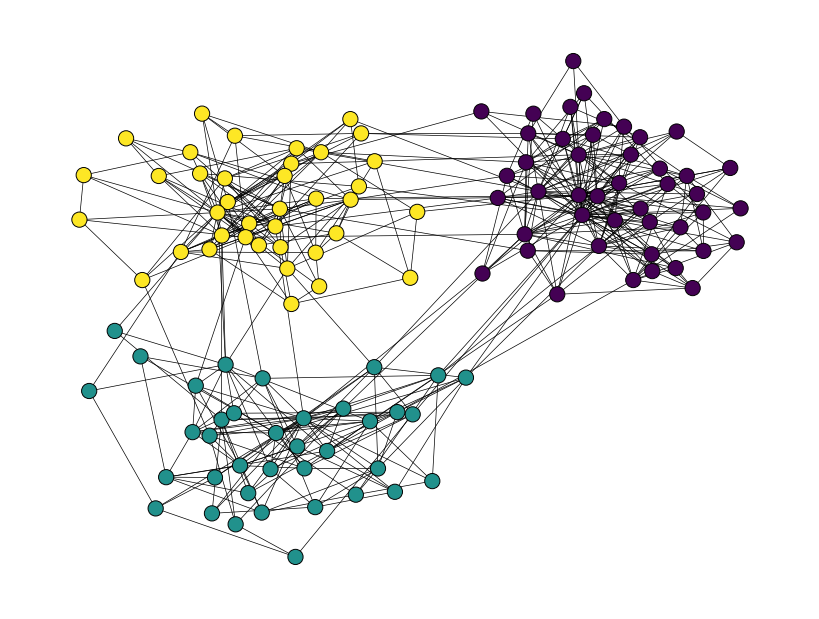

In [131]:
plt.figure(figsize=(8,6))
pos = nx.spring_layout(base_G,k=0.25,seed=42)
nx.draw(base_G,pos,node_color=colors,edge_color='black',node_size=120,edgecolors='black',linewidths=0.7,width=0.5 )

# plt.title("Base Graph")
plt.savefig("base.png",dpi=300,bbox_inches='tight', pad_inches=0.2)
plt.show()


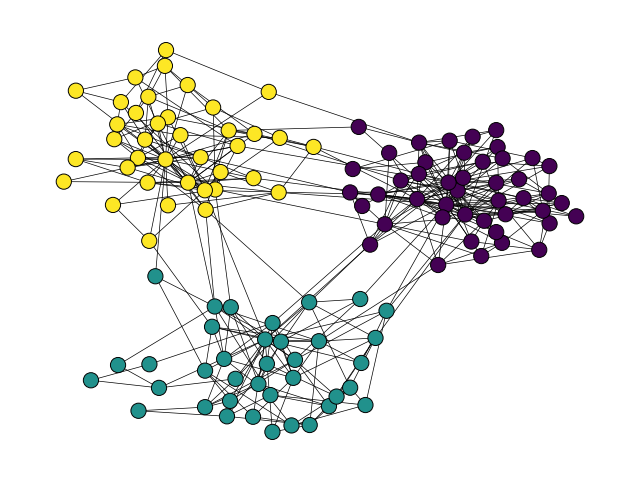

In [259]:
random.seed()
all_edges = base_G.edges()
# intra_edges = []
# inter_edges = []
# for u, v in base_G.edges():
#     if community_map[u] == community_map[v]:
#         intra_edges.append((u,v))
#     else:
#         inter_edges.append((u,v))

# intra_remove_prob = 0.2
# inter_remove_prob = 0.2
# removed_intra_edges = [e for e in intra_edges if random.random() <= intra_remove_prob]
# removed_inter_edges = [e for e in inter_edges if random.random() <= inter_remove_prob]
# removed_edges = removed_intra_edges + removed_intra_edges

removed_edges = [e for e in all_edges if random.random() <= 0.2]

G_mode = base_G.copy()
G_mode.remove_edges_from(removed_edges)

# pos = nx.spring_layout(base_G,k=0.25,seed=42)
pos = nx.spring_layout(G_mode,k=0.25)
plt.figure(figsize=(8,6))
plt.axis('off')

# nx.draw_networkx_nodes(base_G,pos, node_color=colors,node_size=90,edgecolors='black',linewidths=0.5)
# # nx.draw_networkx_edges(base_G,pos, edgelist=removed_edges,style='dotted',edge_color='red',width=0.7)

# nx.draw_networkx_edges(G_mode,pos,edge_color='black',width=0.5)
# # plt.title("20% Edges Removal Graph")

# plt.savefig("removed80.png",dpi=300,bbox_inches='tight', pad_inches=0.2)



nx.draw(G_mode,pos,node_color=colors,edge_color='black',node_size=120,edgecolors='black',linewidths=0.7,width=0.5 )
plt.savefig("removed20_edited.png",dpi=300,bbox_inches='tight', pad_inches=0.2)
plt.show()

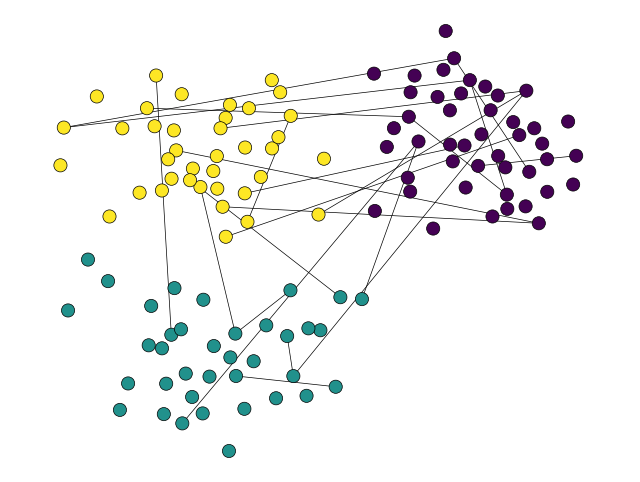

In [174]:
pos = nx.spring_layout(base_G,k=0.25,seed=42)
plt.figure(figsize=(8,6))
plt.axis('off')

nx.draw_networkx_nodes(base_G,pos, node_color=colors,node_size=90,edgecolors='black',linewidths=0.5)
# nx.draw_networkx_edges(graphs[3],pos, edgelist=removed_edges,style='dotted',edge_color='red',width=0.7)

nx.draw_networkx_edges(graphs[3],pos,edge_color='black',width=0.5)

# plt.savefig("removed80.png",dpi=300,bbox_inches='tight', pad_inches=0.2)
plt.show()

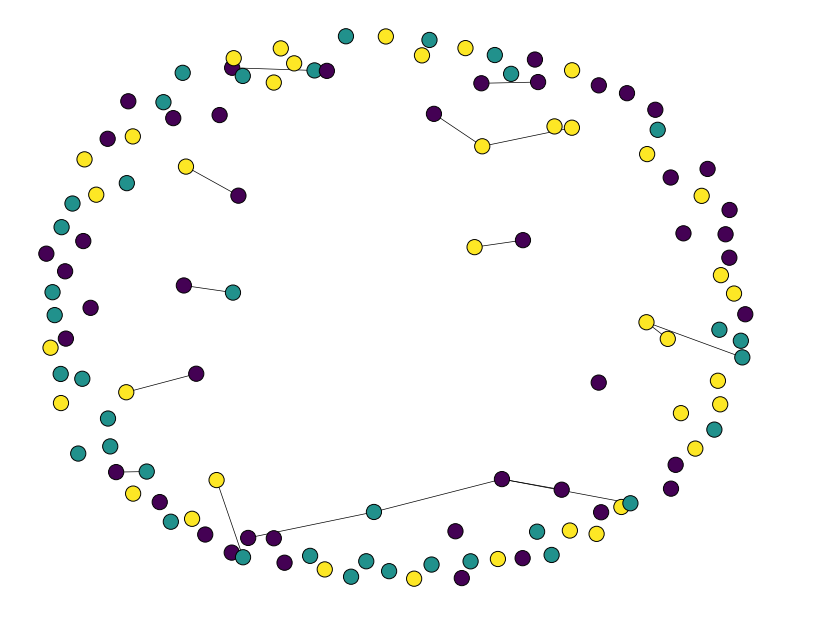

In [303]:
plt.figure(figsize=(8,6))
pos = nx.spring_layout(graphs[3],k=0.35,seed=42)
nx.draw(graphs[3],pos,node_color=colors,edge_color='black',node_size=120,edgecolors='black',linewidths=0.7,width=0.5 )

# plt.title("Base Graph")
plt.savefig("config3-3.png",dpi=300,bbox_inches='tight', pad_inches=0.2)
plt.show()

In [198]:
mu_120, rand_120 = replicate(5,params_base_model,params_syn_model,with_base=False)

replicate number:  0
Simple graph info:  Graph with 120 nodes and 479 edges
number of communities:  3
largest node id, largest node degree (50, 45)
generated graph:  Graph with 120 nodes and 68 edges
generated graph:  Graph with 120 nodes and 48 edges
generated graph:  Graph with 120 nodes and 37 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 120 nodes and 479 edges
number of communities:  3


/var/folders/yv/p4gc61fs20ggtyx7cz1dzt6m0000gn/T/ipykernel_21716/854696862.py:17: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(mat,k=embed_dim)


largest node id, largest node degree (50, 45)
generated graph:  Graph with 120 nodes and 65 edges
generated graph:  Graph with 120 nodes and 45 edges
generated graph:  Graph with 120 nodes and 25 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 120 nodes and 479 edges
number of communities:  3
largest node id, largest node degree (50, 45)
generated graph:  Graph with 120 nodes and 89 edges
generated graph:  Graph with 120 nodes and 48 edges
generated graph:  Graph with 120 nodes and 25 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  3
Simple graph info:  Graph with 120 nodes and 479 edges
number of communities:  3
largest node id, largest node degree (50, 45)
generated graph:  Graph with 120 nodes and 78 edges
generated graph:  Graph with 120 nodes and 49 edges
generated graph:  Graph with 120 nodes and 37 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  4
Simple graph info:  Graph with 120

In [199]:
print(mu_120)
print(rand_120)

[[np.float64(0.4), np.float64(0.3076923076923077), np.float64(0.4), np.float64(0.38461538461538464), np.float64(0.5)], [np.float64(0.3181818181818182), np.float64(0.3), np.float64(0.21739130434782608), np.float64(0.5384615384615384), np.float64(0.5454545454545454)], [np.float64(0.28), np.float64(0.5555555555555556), np.float64(0.34782608695652173), np.float64(0.4230769230769231), np.float64(0.5789473684210527)], [np.float64(0.3793103448275862), np.float64(0.34375), np.float64(0.375), np.float64(0.3888888888888889), np.float64(0.32)], [np.float64(0.4583333333333333), np.float64(0.375), np.float64(0.2857142857142857), np.float64(0.4090909090909091), np.float64(0.27586206896551724)]]
[[np.float64(0.32), np.float64(0.2692307692307692), np.float64(0.4), np.float64(0.38461538461538464), np.float64(0.3333333333333333)], [np.float64(0.36363636363636365), np.float64(0.4), np.float64(0.34782608695652173), np.float64(0.5384615384615384), np.float64(0.5)], [np.float64(0.4), np.float64(0.4814814814

In [200]:
averaged_perf(5,mu_120,rand_120)

0.38832610654335975
0.08133303889521447
0.40830990052773763
0.05729915953519991


Base graph only

In [281]:
params_base = {
    'n'                : 1000,           # desired size
    'tau1'             : 2.5,
    'tau2'             : 1.5,            # power-law exponent for degree distribution (typically 2 < tau < 3), community size distribution
    'mu'               : 0.15,           # percentage % of each node’s links leave its community, 0.1–0.3 is realistic for biological networks
    'avg_degree'       : 20,             # typical PPI mean degree, average degree
    'max_degree'       : 100,            # hubs
    'min_community'    : 15,             # typical small community sizes (e.g., protein complexes)
    'max_community'    : 100,            # upper bound for community sizes
    'seed'             : None
}
params_syn = {
    'num_graph'        : 0,
    'percentage_list'  :[0.7,0.4],
    'p_intra_list'     :[0.08,0.05],
    'p_inter_list'     :[0.002,0.01],
    'p_disconnect_list':[0.001,0.001]
}

In [ ]:
base_G, labels, folds, communities = generate_base_graph(**params_base)

Simple graph info:  Graph with 1000 nodes and 12581 edges
number of communities:  25
largest node id, largest node degree (528, 103)


In [41]:
for idx, comm in enumerate(communities, start=1):
    print(f"Community {idx:02d}, size = {len(comm)}")
    print(list(comm))

Community 01, size = 47
[388, 143, 17, 150, 536, 26, 283, 27, 34, 307, 695, 187, 320, 961, 450, 323, 64, 968, 457, 329, 459, 200, 333, 206, 847, 74, 202, 722, 341, 89, 602, 860, 99, 872, 747, 108, 877, 880, 754, 498, 628, 117, 502, 631, 764, 510, 255]
Community 02, size = 45
[897, 771, 645, 139, 140, 654, 274, 403, 20, 923, 285, 288, 440, 708, 581, 325, 70, 453, 969, 458, 335, 209, 723, 725, 603, 988, 220, 990, 478, 223, 353, 350, 611, 740, 484, 100, 235, 493, 368, 756, 373, 245, 375, 766, 383]
Community 03, size = 63
[265, 656, 785, 16, 405, 22, 895, 281, 793, 155, 924, 284, 156, 667, 800, 153, 930, 547, 295, 683, 944, 689, 562, 305, 950, 566, 823, 310, 699, 316, 955, 318, 61, 703, 66, 709, 72, 585, 970, 203, 77, 339, 597, 86, 472, 734, 222, 867, 996, 228, 614, 999, 616, 490, 621, 752, 499, 884, 120, 122, 763, 125, 127]
Community 04, size = 17
[195, 838, 199, 914, 83, 959, 989, 161, 164, 294, 171, 174, 303, 945, 179, 53, 575]
Community 05, size = 37
[132, 5, 135, 136, 780, 653, 18, 23

In [49]:
graphs, syn_nets = generate_syn_graph(base_G,communities,**params_syn)

In [50]:
syn_nets.shape

(1, 1000, 1000)

In [79]:
A_masked = mask_symmetric_ones(syn_nets[0,:,:], frac=0.2, seed=None, keep_diagonal=True)

In [81]:
syn_nets1 = syn_nets.copy()
syn_nets1[0,:,:] = A_masked
mu_res, rand_res = run_synthetic_pipeline(syn_nets1, labels, folds)
print(mu_res)
print(rand_res)

fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.995)]
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.995)]


In [103]:
mu_rep_list = []
rand_rep_list = []
for rep in range(10):
    print("replicate number: ",rep)
    syn_nets1 = np.zeros((2,1000,1000))
    A_masked = mask_symmetric_ones(syn_nets[0,:,:], frac=0.2, seed=None, keep_diagonal=True)
    syn_nets1[0,:,:] = syn_nets[0,:,:]
    syn_nets1[1,:,:] = A_masked
    mu_res, rand_res = run_synthetic_pipeline(syn_nets1, labels, folds)
    mu_rep_list.append(mu_res)
    rand_rep_list.append(rand_res)

replicate number:  0
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  3
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  4
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  5
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  6
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  7
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  8
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  9
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5


In [104]:
averaged_perf(mu_rep_list,rand_rep_list)

0.9997000000000001
0.0006000000000000005
0.9987
0.0015797958971132727


In [80]:
np.sum(A_masked)

np.float64(20130.0)

In [77]:
np.sum(syn_nets[0,:,:])

np.float64(25162.0)

In [52]:
mu_res, rand_res = run_synthetic_pipeline(syn_nets, labels, folds)
print(mu_res)
print(rand_res)

fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


In [88]:
mu_rep_list, rand_rep_list = replicate(10,params)

replicate number:  0
Multi graph info:  Graph with 1000 nodes and 12986 edges
Simple graph info:  Graph with 1000 nodes and 12762 edges
number of communities:  21
largest node id, largest node degree (951, 99)
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
replicate number:  1
Multi graph info:  Graph with 1000 nodes and 13059 edges
Simple graph info:  Graph with 1000 nodes and 12778 edges
number of communities:  29
largest node id, largest node degree (914, 100)
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
replicate number:  2
Multi graph info:  Graph with 1000 nodes and 13341 edges
Simple graph info:  Graph with 1000 nodes and 13143 edges
number of communities:  20
largest node id, largest node degree (244, 99)
fold:  0
fold:  1
fold:  2
fold:  3
fold:  4
replicate number:  3
Multi graph info:  Graph with 1000 nodes and 12376 edges
Simple graph info:  Graph with 1000 nodes and 12071 edges
number of communities:  33
largest node id, largest node degree (222, 100)
fold:  0
fold:  1
fold:

In [89]:
print(mu_rep_list)
print(rand_rep_list)

[[np.float64(0.82), np.float64(0.785), np.float64(0.815), np.float64(0.785), np.float64(0.52)], [np.float64(0.73), np.float64(0.695), np.float64(0.775), np.float64(0.78), np.float64(0.75)], [np.float64(0.795), np.float64(0.775), np.float64(0.825), np.float64(0.815), np.float64(0.775)], [np.float64(0.69), np.float64(0.69), np.float64(0.72), np.float64(0.795), np.float64(0.73)], [np.float64(0.91), np.float64(0.805), np.float64(0.95), np.float64(0.76), np.float64(0.8)], [np.float64(0.835), np.float64(0.815), np.float64(0.795), np.float64(0.805), np.float64(0.775)], [np.float64(0.765), np.float64(0.915), np.float64(0.805), np.float64(0.435), np.float64(0.74)], [np.float64(0.705), np.float64(0.265), np.float64(0.625), np.float64(0.735), np.float64(0.695)], [np.float64(0.74), np.float64(0.76), np.float64(0.68), np.float64(0.72), np.float64(0.765)], [np.float64(0.7), np.float64(0.825), np.float64(0.74), np.float64(0.76), np.float64(0.72)]]
[[np.float64(0.9), np.float64(0.885), np.float64(0.92

In [90]:
mu_mean_list = []
mu_std_list = []
rand_mean_list = []
rand_std_list = []
for i in range(10):
    mu_mean_list.append(np.mean(mu_rep_list[i]))
    mu_std_list.append(np.std(mu_rep_list[i]))
    rand_mean_list.append(np.mean(rand_rep_list[i]))
    rand_std_list.append(np.std(rand_rep_list[i]))
print(np.mean(mu_mean_list))
print(np.mean(mu_std_list))
print(np.mean(rand_mean_list))
print(np.mean(rand_std_list))

0.7482
0.0703526412347736
0.9171000000000001
0.020589943980314176


In [30]:
params_syn2 = {
    'num_graph'        : 3,
    'percentage_list'  :[0.8,0.8,0.8],
    'p_intra_list'     :[0.2,0.2,0.2],
    'p_inter_list'     :[0.005,0.005,0.005],
    'p_disconnect_list':[0.005,0.005,0.005]
}

In [41]:
mu_rep_list2, rand_rep_list2 = replicate(10,params_base,params_syn2,with_base=True)

replicate number:  0
Simple graph info:  Graph with 1000 nodes and 12278 edges
number of communities:  19
largest node id, largest node degree (661, 95)
generated graph:  Graph with 1000 nodes and 7777 edges
generated graph:  Graph with 1000 nodes and 7878 edges
generated graph:  Graph with 1000 nodes and 7815 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12180 edges
number of communities:  26
largest node id, largest node degree (347, 96)
generated graph:  Graph with 1000 nodes and 6852 edges
generated graph:  Graph with 1000 nodes and 6893 edges
generated graph:  Graph with 1000 nodes and 6730 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 1000 nodes and 12191 edges
number of communities:  23
largest node id, largest node degree (415, 99)
generated graph:  Graph with 1000 nodes and 7117 edges
generated graph:  Graph with 1000 nodes and 7251 edges
generated g

In [42]:
print(mu_rep_list2)
print(rand_rep_list2)

[[np.float64(0.965), np.float64(0.98), np.float64(0.955), np.float64(0.975), np.float64(0.97)], [np.float64(0.94), np.float64(0.945), np.float64(0.955), np.float64(0.79), np.float64(0.945)], [np.float64(0.97), np.float64(0.955), np.float64(0.955), np.float64(0.72), np.float64(0.96)], [np.float64(0.96), np.float64(0.965), np.float64(0.955), np.float64(0.91), np.float64(0.92)], [np.float64(0.94), np.float64(0.95), np.float64(0.93), np.float64(0.905), np.float64(0.035)], [np.float64(0.885), np.float64(0.96), np.float64(0.955), np.float64(0.935), np.float64(0.93)], [np.float64(0.935), np.float64(0.965), np.float64(0.83), np.float64(0.95), np.float64(0.925)], [np.float64(0.875), np.float64(0.91), np.float64(0.93), np.float64(0.93), np.float64(0.925)], [np.float64(0.77), np.float64(0.915), np.float64(0.775), np.float64(0.95), np.float64(0.955)], [np.float64(0.935), np.float64(0.77), np.float64(0.845), np.float64(0.92), np.float64(0.955)]]
[[np.float64(0.99), np.float64(0.99), np.float64(0.98

In [43]:
averaged_perf(mu_rep_list2,rand_rep_list2)

0.9015999999999998
0.07953403374111752
0.978
0.008937472402288666


In [44]:
params_syn3 = {
    'num_graph'        : 3,
    'percentage_list'  :[0.8,0.6,0.4],
    'p_intra_list'     :[0.2,0.2,0.2],
    'p_inter_list'     :[0.005,0.005,0.005],
    'p_disconnect_list':[0.005,0.005,0.005]
}

In [49]:
mu_rep_list3, rand_rep_list3 = replicate(10,params_base,params_syn3,with_base=True)

replicate number:  0
Simple graph info:  Graph with 1000 nodes and 12063 edges
number of communities:  23
largest node id, largest node degree (583, 98)
generated graph:  Graph with 1000 nodes and 7344 edges
generated graph:  Graph with 1000 nodes and 4891 edges
generated graph:  Graph with 1000 nodes and 2734 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12456 edges
number of communities:  32
largest node id, largest node degree (708, 101)
generated graph:  Graph with 1000 nodes and 6394 edges
generated graph:  Graph with 1000 nodes and 4311 edges
generated graph:  Graph with 1000 nodes and 2569 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Failed with error: Could not assign communities; try increasing min_community. Retrying...
Failed with error: Could not assign communities; try increasing min_community. Retrying...
Simple graph info:  Graph with 1000 nodes and 12343 edges
number of co

In [50]:
print(mu_rep_list3)
print(rand_rep_list3)

[[np.float64(0.865), np.float64(0.89), np.float64(0.685), np.float64(0.855), np.float64(0.89)], [np.float64(0.85), np.float64(0.35), np.float64(0.39), np.float64(0.855), np.float64(0.85)], [np.float64(0.895), np.float64(0.895), np.float64(0.335), np.float64(0.18), np.float64(0.855)], [np.float64(0.77), np.float64(0.94), np.float64(0.945), np.float64(0.755), np.float64(0.205)], [np.float64(0.045), np.float64(0.935), np.float64(0.96), np.float64(0.77), np.float64(0.915)], [np.float64(0.93), np.float64(0.935), np.float64(0.93), np.float64(0.075), np.float64(0.78)], [np.float64(0.78), np.float64(0.84), np.float64(0.825), np.float64(0.85), np.float64(0.82)], [np.float64(0.17), np.float64(0.83), np.float64(0.83), np.float64(0.87), np.float64(0.95)], [np.float64(0.815), np.float64(0.775), np.float64(0.085), np.float64(0.045), np.float64(0.795)], [np.float64(0.05), np.float64(0.655), np.float64(0.535), np.float64(0.885), np.float64(0.94)]]
[[np.float64(0.97), np.float64(0.955), np.float64(0.97

In [51]:
averaged_perf(mu_rep_list3,rand_rep_list3)

0.6975
0.25574594597036215
0.9568
0.010119948217771037


In [286]:
params_syn4 = {
    'num_graph'        : 3,
    'percentage_list'  :[0.2,0.2,0.2],
    'p_intra_list'     :[0.005,0.005,0.005],
    'p_inter_list'     :[0.005,0.005,0.005],
    'p_disconnect_list':[0.005,0.005,0.005]
}

In [288]:
mu_rep_list4, rand_rep_list4 = replicate(10,params_base,params_syn4,with_base=True)

replicate number:  0
Failed with error: Could not assign communities; try increasing min_community. Retrying...
Simple graph info:  Graph with 1000 nodes and 12483 edges
number of communities:  23
largest node id, largest node degree (636, 97)
generated graph:  Graph with 1000 nodes and 899 edges
generated graph:  Graph with 1000 nodes and 902 edges
generated graph:  Graph with 1000 nodes and 944 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12135 edges
number of communities:  31
largest node id, largest node degree (855, 99)
generated graph:  Graph with 1000 nodes and 942 edges
generated graph:  Graph with 1000 nodes and 936 edges
generated graph:  Graph with 1000 nodes and 984 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 1000 nodes and 12437 edges
number of communities:  25
largest node id, largest node degree (117, 102)
generated graph:  Graph with 1000 n

In [289]:
print(mu_rep_list4)
print(rand_rep_list4)

[[np.float64(0.225), np.float64(0.34), np.float64(0.24), np.float64(0.08), np.float64(0.055)], [np.float64(0.23), np.float64(0.18), np.float64(0.53), np.float64(0.255), np.float64(0.06)], [np.float64(0.51), np.float64(0.075), np.float64(0.225), np.float64(0.435), np.float64(0.165)], [np.float64(0.23), np.float64(0.31), np.float64(0.04), np.float64(0.265), np.float64(0.515)], [np.float64(0.155), np.float64(0.175), np.float64(0.305), np.float64(0.085), np.float64(0.29)], [np.float64(0.415), np.float64(0.28), np.float64(0.35), np.float64(0.365), np.float64(0.065)], [np.float64(0.065), np.float64(0.365), np.float64(0.22), np.float64(0.065), np.float64(0.045)], [np.float64(0.365), np.float64(0.07), np.float64(0.205), np.float64(0.295), np.float64(0.25)], [np.float64(0.075), np.float64(0.135), np.float64(0.5), np.float64(0.535), np.float64(0.23)], [np.float64(0.29), np.float64(0.52), np.float64(0.08), np.float64(0.04), np.float64(0.38)]]
[[np.float64(0.915), np.float64(0.855), np.float64(0.8

In [290]:
averaged_perf(10,mu_rep_list4,rand_rep_list4)

0.24359999999999998
0.13765552295570668
0.8261
0.036418946981339524


In [291]:
params_syn5 = {
    'num_graph'        : 1,
    'percentage_list'  :[0.2],
    'p_intra_list'     :[0.005],
    'p_inter_list'     :[0.005],
    'p_disconnect_list':[0.005]
}

In [296]:
mu_rep_list5, rand_rep_list5 = replicate(10,params_base,params_syn5,with_base=False)

replicate number:  0
Failed with error: Could not assign communities; try increasing min_community. Retrying...
Simple graph info:  Graph with 1000 nodes and 12693 edges
number of communities:  23
largest node id, largest node degree (798, 98)
generated graph:  Graph with 1000 nodes and 868 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  1
Simple graph info:  Graph with 1000 nodes and 12519 edges
number of communities:  26
largest node id, largest node degree (377, 97)
generated graph:  Graph with 1000 nodes and 935 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  2
Simple graph info:  Graph with 1000 nodes and 11873 edges
number of communities:  24
largest node id, largest node degree (927, 100)
generated graph:  Graph with 1000 nodes and 914 edges
fold:  1
fold:  2
fold:  3
fold:  4
fold:  5
replicate number:  3
Simple graph info:  Graph with 1000 nodes and 12394 edges
number of communities:  24
largest node id, largest node degree (599, 97)

In [297]:
print(mu_rep_list5)
print(rand_rep_list5)

[[np.float64(0.065), np.float64(0.05), np.float64(0.07), np.float64(0.09), np.float64(0.06)], [np.float64(0.075), np.float64(0.065), np.float64(0.05), np.float64(0.085), np.float64(0.1)], [np.float64(0.065), np.float64(0.055), np.float64(0.095), np.float64(0.08), np.float64(0.06)], [np.float64(0.05), np.float64(0.085), np.float64(0.06), np.float64(0.08), np.float64(0.05)], [np.float64(0.03), np.float64(0.055), np.float64(0.055), np.float64(0.035), np.float64(0.045)], [np.float64(0.025), np.float64(0.05), np.float64(0.035), np.float64(0.06), np.float64(0.045)], [np.float64(0.07), np.float64(0.045), np.float64(0.02), np.float64(0.06), np.float64(0.04)], [np.float64(0.085), np.float64(0.045), np.float64(0.05), np.float64(0.07), np.float64(0.075)], [np.float64(0.06), np.float64(0.03), np.float64(0.065), np.float64(0.055), np.float64(0.03)], [np.float64(0.075), np.float64(0.055), np.float64(0.04), np.float64(0.04), np.float64(0.085)]]
[[np.float64(0.06), np.float64(0.065), np.float64(0.085)

In [298]:
averaged_perf(10,mu_rep_list5,rand_rep_list5)

0.05840000000000001
0.014771747102370562
0.06000000000000001
0.012771689073479697


Synthetic test for mashup

In [21]:
syn_files = [1,2]
syn_nets = np.load('syn_nets.npy')
syn_train_anno = np.load('sythetic_train_anno.npy')
syn_test_anno = np.load('sythetic_test_anno.npy')
syn_walks = compute_rwr_original_sparse(syn_files,0.5,1000,syn_nets)
syn_x = svd_embed_sparse_func(syn_walks, 1000, 400)
syn_mu_dist_mat, syn_mu_knn = get_knn_ind(syn_x,syn_train_anno)
syn_mu_scores, syn_mu_num_voters,syn_mu_voters = majority_vote(syn_mu_dist_mat, syn_mu_knn, syn_train_anno, syn_test_anno,10)
syn_mu_acc,syn_mu_correct_pred_ind = acc_top1_pred(syn_mu_scores, syn_test_anno)
syn_mu_f1,syn_mu_auprc = f1_auprc_pred(syn_mu_scores, syn_test_anno,1)
print(syn_mu_acc,syn_mu_f1,syn_mu_auprc)

0
0
0.06 0.06 0.07807692307692307


Synthetic test for random augmentation

In [22]:
syn_files = [1,2]
syn_nets = np.load('syn_nets.npy')
syn_train_anno = np.load('sythetic_train_anno.npy')
syn_test_anno = np.load('sythetic_test_anno.npy')
syn_rand_cluster = random_split_vector(syn_train_anno,1000, 15,seed=None)
syn_rand_graph = augment_graph(syn_nets, 1000, syn_rand_cluster, 1, -1)
syn_rand_rwr_res = augmented_RWR(syn_rand_graph, 0.5)
syn_rand_x = augmented_SVD_with_cannolink(syn_rand_rwr_res, 400)
syn_rand_dist_mat, syn_rand_knn = get_knn_ind(syn_rand_x,syn_train_anno)
syn_rand_scores, syn_rand_num_voters,rand_voters = majority_vote(syn_rand_dist_mat, syn_rand_knn, syn_train_anno, syn_test_anno,10, weighted=True)
syn_rand_acc, syn_rand_correct_pred_ind = acc_top1_pred(syn_rand_scores, syn_test_anno)
syn_rand_f1,syn_rand_auprc = f1_auprc_pred(syn_rand_scores, syn_test_anno,1)
print(syn_rand_acc,syn_rand_f1,syn_rand_auprc)

0
0
0.07 0.07 0.0878846153846154


In [121]:
rand_runs = [0.94,0.955,0.955,0.96,0.96,0.955,0.95,0.95,0.955,0.945]
rand_runs = np.array(rand_runs)
print(np.mean(rand_runs),np.std(rand_runs))

0.9525 0.0060207972893961525
